In [1]:
# Import Required Packages
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [2]:
# Load the vocal Signal that will be treated later on , in this case ; it's called "rec1.wav"

y, sr = librosa.load('rec1.wav', duration=9)

In [3]:

# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

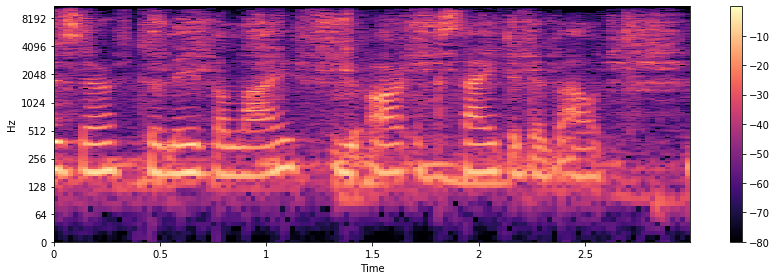

In [4]:
#Pick a slice of 3 seconds (from the 2nd to the 4h) from the signal to test on and plot its corresponding spectrum

idx = slice(*librosa.time_to_frames([2, 5], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [5]:

# The descretization will proceed by comparing frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

In [6]:
# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [7]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

In [8]:
# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

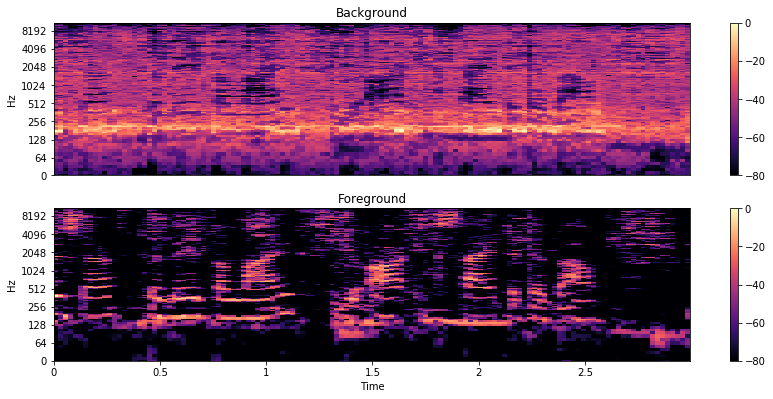

In [9]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
#plt.subplot(3, 1, 1)
#librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         #y_axis='log', sr=sr)
#plt.title('Full spectrum')
#plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [10]:

# take a look at what out input data looks like to know how to deal with it properly
S_foreground

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.1333046e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.2115523e-07,
        0.0000000e+00, 1.1303333e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.4593202e-04,
        0.0000000e+00, 9.4343815e-03],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.7690840e-03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.5269506e-03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        7.2674138e-06, 3.6760860e-03]], dtype=float32)

In [11]:

# Check the shape of our matrix
S_foreground.shape

(1025, 354)

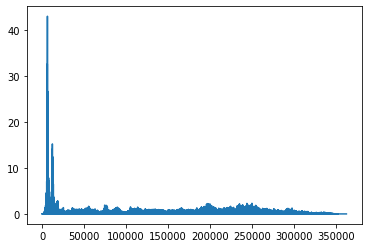

In [16]:
# Flatten the Foreground matrix into one vector
from numpy import matrix
ra = np.ravel(S_foreground)

#plot it
plt.plot(ra)
plt.show()

In [17]:
# Now that we have a filtered version of our signal , let's listen to it #######

import pyaudio
p = pyaudio.PyAudio()

s_rate = 48000

volume = 0.5     # range [0.0, 1.0]
duration = 9   # in seconds, may be float
# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=s_rate,
                output=True)


In [18]:
# play it !!!
stream.write(ra)
stream.stop_stream()
stream.close()
p.terminate()

In [15]:
# Recognize the speech from our signal ""if the speech is clear enough"" , and turn it into text via Google voice

# import speech_recognition as sr

# r = sr.Recognizer()
# harvard = sr.AudioFile(ra)
# with harvard as source:
#     audio = r.record(source)
#     type(audio)
# r.recognize_google(audio)